## Twitter Sentiment Analysis - Tutorial follow along

In [13]:
# Tutorial: https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c
# Tutorial Requirements

#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [187]:
# I moved the training data to a seperate folder to
# keep files better organized.
training_csv_filepath = "./raw-data/train_tweets.csv"
testing_csv_filepath = "./raw-data/test_tweets.csv"

train_tweets = pd.read_csv(training_csv_filepath)
test_tweets = pd.read_csv(testing_csv_filepath)

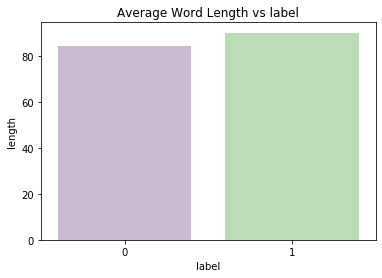

In [188]:
# Learning how to mess with data with pandas!!!

# Instead of a lambda: Tweet(sentence) Length
def tweetLength(tweet):
    return len(tweet)

# create a new column called length equaling tweet lengths.
train_tweets['length'] = train_tweets['tweet'].apply(tweetLength)

# get the average tweet length for the label: '0' & '1'
word_length_average = train_tweets.groupby('label')['length'].mean().reset_index()

# now that the data has been updated we can show a chart that matches the tutorial
chart = sns.barplot(x = 'label', y = 'length', data = word_length_average, palette='PRGn')
plt.title("Average Word Length vs label")
plt.show(chart)

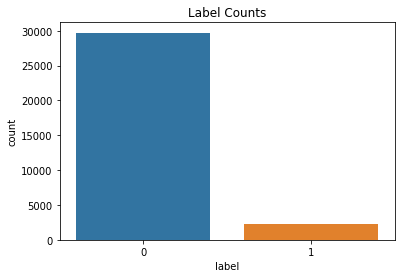

In [189]:
# standard categorical count of the 'label' column
groupedvalues = train_tweets.groupby('label').size().reset_index()
groupedvalues.rename(columns = {0:'count'}, inplace = True)

# alternate method
# count = train_tweets['label'].value_counts()
# count.to_frame()

chart = sns.barplot(x = 'label', y = 'count', data = groupedvalues)
plt.title('Label Counts')
plt.show(chart)

## Tweet Cleaning

In [126]:
# Remove Punctuations
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

print(form_sentence(train_tweets['tweet'].iloc[10]))
print(train_tweets['tweet'].iloc[10])

â ireland consumer price index mom climbed from previous 0.2 to 0.5 in may blog silver gold forex
 â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex


In [130]:
# Removing stopwords that don't have sentiment values (is, are, have, etc.)
def no_user_alpha(tweet):
    
    tweet_list = []
    for ele in tweet.split():
        if ele != 'user':
            tweet_list.append(ele)
            
    clean_tokens = []
    for t in tweet_list:
        # regex matching
        if re.match(r'[^\W\d]*$', t):
            clean_tokens.append(t)
            
    clean_sentence = ' '.join(clean_tokens)
    
    clean_mess = []
    for word in clean_sentence.split():
        if word.lower() not in stopwords.words('english'):
            clean_mess.append(word)
            
    return clean_mess

print(no_user_alpha(form_sentence(train_tweets['tweet'].iloc[10])))
print(train_tweets['tweet'].iloc[10])

['ireland', 'consumer', 'price', 'index', 'mom', 'climbed', 'previous', 'may', 'blog', 'silver', 'gold', 'forex']
 â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex


In [139]:
# Lexicon Normalization - so plays, played, playing = play, etc.
def normalization(tweet):
    
    lem = WordNetLemmatizer()
    
    normalized_tweet = []
    for word in tweet:
        # 'wordnet' needs to be downloaded for nltk
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
        
    return normalized_tweet

tweet_test = 'I was playing with my friends with whom I used to play, when you called me yesterday'.split()
print(normalization(tweet_test))

['I', 'be', 'play', 'with', 'my', 'friends', 'with', 'whom', 'I', 'use', 'to', 'play,', 'when', 'you', 'call', 'me', 'yesterday']


In [190]:
def text_processing(tweet):
    new_tweet = form_sentence(tweet)
    no_punc_tweet = no_user_alpha(new_tweet)
    return normalization(no_punc_tweet)

train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

In [147]:
train_tweets[train_tweets['label']==1].drop('tweet',axis=1).head()

,id,label,length,tweet_list
13,14,1,74,"[cnn, call, michigan, middle, school, wall, ch..."
14,15,1,101,"[comment, australia, opkillingbay, seashepherd..."
17,18,1,22,"[retweet, agree]"
23,24,1,47,"[lumpy, say, prove, lumpy]"
34,35,1,104,"[unbelievable, century, need, something, like,..."


## Machine Learning!

**Tf(d,f)** - Term frequency

**Idf(t)** - Inverse document of frequency = log(total documents/documents with the term)

In [150]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = text_processing)), # strings to token intege counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()), # train on TF-IDF vectore w/ Navie Bayes classifier
])

In [151]:
msg_train, msg_test, label_train, label_test = train_test_split(
    train_tweets['tweet'],
    train_tweets['label'],
    test_size = 0.2
)

pipeline.fit(msg_train, label_train)
predictions = pipeline.predict(msg_test)

print(classification_report(predictions, label_test))
print(confusion_matrix(predictions, label_test))
print(accuracy_score(predictions, label_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6323
           1       0.15      0.99      0.26        70

    accuracy                           0.94      6393
   macro avg       0.57      0.96      0.61      6393
weighted avg       0.99      0.94      0.96      6393

[[5927  396]
 [   1   69]]
0.9379008290317535


In [191]:
indicies = msg_test.index
for i, p in enumerate(predictions):
    if p == 1:
#         print('positive ' + str(i))
        org = indicies[i]
        print(' '.join(train_tweets.loc[org]['tweet_list']))



pueorico environmental injustice inflame protest coal ash
lgbtqhatestrumppay luvs homophobic misogynist antisemitic death cult masquerade religion
sikh temple vandalise calgary wso condemn act
black amp feel like stomp retweet tampa
think factory polarisation trump leadership politics brexit blm
might libtard libtard sjw liberal politics
hispanic feel like stomp listen retweet
might libtard libtard sjw liberal politics
might libtard libtard sjw liberal politics
feminismiscancer feminismisterrorism feminismmuktbharat malevote ignore
sikh temple vandalise calgary wso condemn act
sea shepherd suppoers racist antiracism seashepherd
ramble alt right blacktwitter tcot tlot altright bcot blacklivesmatter
sikh temple vandalise calgary wso condemn act
feminismiscancer feminismisterrorism feminismmuktbharat malevote ignore
adam saleh racist adamsaleh
allahsoil rapacious hunger oil also seal doom
sea shepherd suppoers racist antiracism seashepherd
originally mean white landholding
people protest 